# PhenoLeaf : A comprehensive tutorial

This document aims to explain how each function in the PhenoLeaf package work. It is not any kind of defined workflow to perform analysis on leaf rosette

First you need to import all the functions that are containe into PL_code.py

In [1]:
import importlib

def import_all_from_file(file_path):
    """
    Objective:
    This function imports all functions, libraries, and modules from a specified .py file and makes them available in the current module.

    Input variables:
    - file_path (str): The path to the .py file containing the functions, libraries, and modules to be imported.

    Output variables:
    None
    """

    module_name = "temp_module"  # Temporary module name
    try:
        spec = importlib.util.spec_from_file_location(module_name, file_path)
        module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(module)

        # Import all names from the module into the current local module
        globals().update(vars(module))
    except FileNotFoundError:
        print(f"The file {file_path} was not found.")
    except Exception as e:
        print(f"Error while importing functions: {e}")

# Path to the file containing the functions, libraries, and modules to be imported
file_path = "/home/mcaroulle/Pheno_Leaf/PL_Final/PL_code.py"

# Calling the function to import everything from the specified file
import_all_from_file(file_path)

## Functions related to image correction

### Optical distortion correction

Images of full tray displays some defects which may be linked to optical distortion.
It is observed a barrel type of radial distortion i.e. plants at the center of the tray tends to be bigger than they are and conversly plants at the edges of the tray tends to be small. Optical distortions also tiggers modifications in shapes and sizes of image's pixels. The causes of image optical-distortion can be various (due to inegal lens magnification, camera sensor, non parrallel plane-object).


Thus it is necessary to fix these kinds of optical defects. We use an open-source python package named "Discorpy" wich github repository can be found here https://github.com/algotom/discorpy/tree/master

This package use a 3 step process:
- pre-processing : extracting and grouping reference-points from a calibration image
- processing : caculation of coefficients of correction for the model
- post-processing : correcting images

All the functions in pre_process are part of the discorpy package go on discorpy github to understand the aim of these functions. 

The following code, perform optical correction distortion on all the images contained in a input directory and save the output in an output directory.

### Image cropping

To perform analysis on the segmented images, the objects i.e. here the plants needs to be spaced regularly. Thus it is required to croop images before further steps. 
Here we manually crop the images generated above using Adobe Photoshop, but it can be implemented via python according following process: add color marks on the tray at each corner, make a copy of the image, color segment to target the choosen colors for the marks, then fin the bounding box, extract it coordinates and apply them to the image.

### Image scaling

To scale the image, we use a basic approach by measuring a known distance with Fiji and save the results in a CSV table. 
But it cans be implemented via python via following process: add a color scale on the tray (e.g. a 2 cm squared squared), color segment the image targeting the choosen color, measure area, then extract pixel number, make conversion and save scale. 

## Image segmentation

Image segmentation can be performed via two different ways. Either you go under a classic color hsv segmentation using color_segmented_image. Or you can use a segmentation based on machine learning via Ilastik.

### Machine learning segmentation via Ilastik

Install Ilastik https://www.ilastik.org 
Then open the GUI of Ilastik
Choose Pixel Classification
Import your image for the training, click on the + (Add new --> Add separated image), then chose the image and set the internal path as TRUE making a copy of the image into the project file. 
On left pannel click on 2. Feature selection and select features, basically the ML algorithm will based his training on theses features.
You need to select them by trial and error, it takes time but it is fundamental
Here for our dataset we choose: 
- Gaussian smoothing sigma = 0.3 and 3.5 (moss) / 1 (cork)
- Laplacian of gaussian sigma = 1.6 / 1
- Gaussian gradient magnitude sigma = 1 / 1
- Difference of gaussians sigma = 1.6 / 1
- Structure tensor eigenvalues sigma = 1.6 / 1
- Hessian of gaussian sigma = 3.5 / 1

On left pannel click on 3. Training, here we need to separate 2 kind of lables : plant and the background
Set 2 labels with two differerent colors, select on the image for each label as few pixel as possible belonging to each label but enougth to train the algoritm. The choose live update and display the segmentation.
If the segmentation is not good you need to select more pixels of the label to be improved. 
If you have struggles go back to Feature selections, select other features and repeat the training.

On left pannel click on 4. Prediction export. you need to select simple segmentation on the left pannel. 

Herer you can either continue on the GUI or save your training and go under bash with the training saved. 
The GUI is way easier to use. 

On left pannel click on 5. Batch processing, select all the images to be processed, it is really important to select the right path, and choose the right way of naming files and the output files. 
Really important, you need to save the output as 8-bits, and select .png. 


As soon as your images are segmented they appears full black. It is beacuase the pixels are taking values between 0 and 255. Thus you need to threshold the images, you can do it by python, but here we choose to do it with Fiji. 
Open Fiji, open the image, go on image, the adjust, then threshold and select move the slider to select onlu pixels between 0 and 2/3 ie you will have the mask (be carefull to select dark backgournd) and finally save the output as png. This process can be a bit long, hoever, it allows you to have an overview on the efficiency on the segmentation by manually checking all the images.

You can now import your segmented images in a folder to work with them under these python commands.

### Color segmentation based on color_segmented_image ()

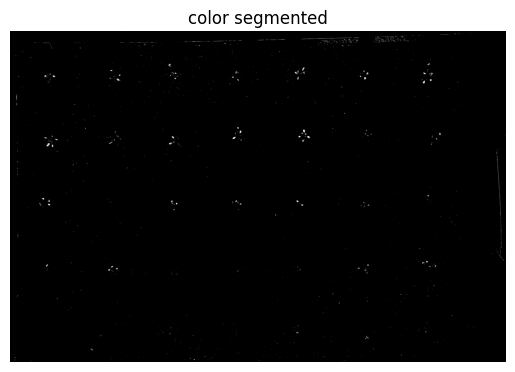

In [2]:
color_segmented_image = color_segmentation('/home/mcaroulle/Pheno_Leaf/PL_Final/RAW_OUTPUT/TRAY21107.JPG')

show_image(color_segmented_image,'color segmented')

## Processing the segmentation mask

### mask_measurements()

   label  area                  coords
0      1   2.0  [[50, 688], [50, 689]]
1      2   1.0            [[73, 1309]]
2      3   1.0            [[77, 2694]]
3      4   1.0              [[88, 66]]
4      5   1.0           [[102, 2276]]


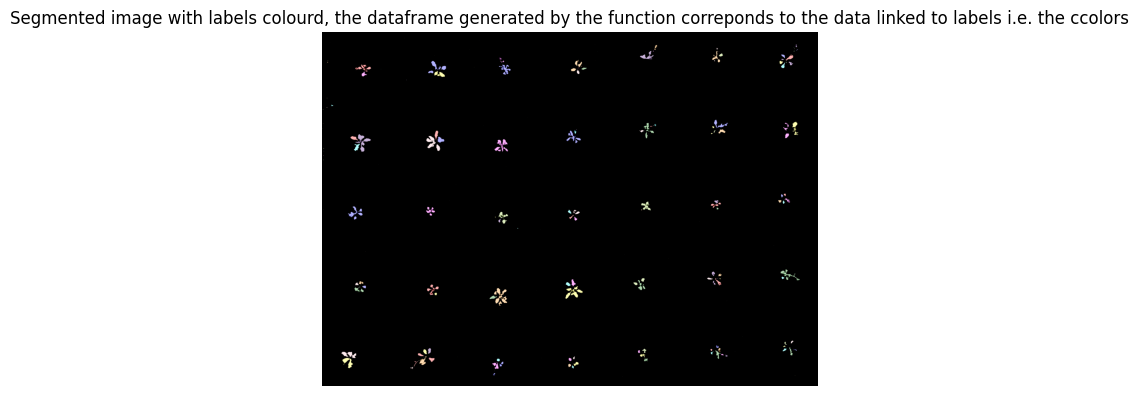

In [2]:
mask=image_to_mask("/home/mcaroulle/Pheno_Leaf/PL_Final/SEGMENTED_INPUT/TRAY11207.png")

df_filtered=mask_measurements(mask)

print(df_filtered.head())

##Operations to diplay intermediate results
closed_mask = nd.binary_closing(mask, np. ones ((7,7)))

label_image= measure.label(closed_mask)

image_label_overlay = label2rgb(label_image, image= mask)

show_image(image_label_overlay, "Segmented image with labels colourd, the dataframe generated by the function correponds to the data linked to labels i.e. the ccolors")



### peak_identification()

   label  area                  coords
0      1   2.0  [[50, 688], [50, 689]]
1      2   1.0            [[73, 1309]]
2      3   1.0            [[77, 2694]]
3      4   1.0              [[88, 66]]
4      5   1.0           [[102, 2276]]


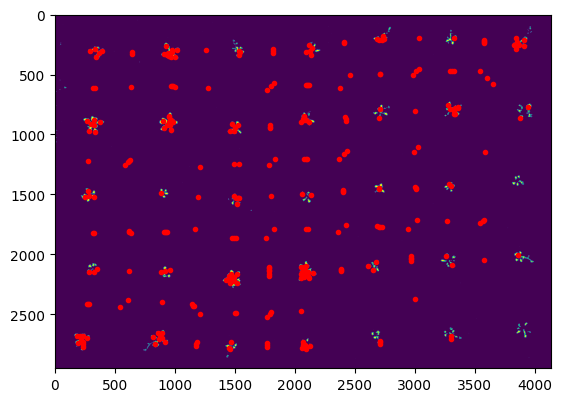

In [3]:
peak_idx=peak_identification(mask)

print(df_filtered.head())

##Operations to diplay intermediate results
#show_image(peak_idx,"Identification of maximum peaks wich correspond to points locate in each labeled object")

plt.plot(peak_idx[:,1],peak_idx[:,0],'r.')
plt.imshow(mask)

### label_coordinates()

In [4]:
df_peak_label = label_coordinates(mask, df_filtered)

### tray_slicing()

In [29]:
mask_path="/home/mcaroulle/Pheno_Leaf/PL_Final/SEGMENTED_INPUT/TRAY11207.png"
r = 5
c = 7

df_tray_min, df_tray_max = tray_slicing(mask_path,r,c)

### assign_pot_to_peak()

In [22]:
df_peak_label = assign_pot_to_peak(df_peak_label, df_tray_min)

### merge_to_plant()

In [23]:
masquefusione_list = merge_to_plant(label_image, df_peak_label)

### split_masks_with_bbox()

In [24]:
output_dir="/home/mcaroulle/Pheno_Leaf/PL_Final/SEGMENTED_OUTPUT"

masks = masquefusione_list 

split_masks_with_bbox(masks, output_dir,mask_path)

### process_mask_dilation

The mask kas been dilated trough 17 dilations


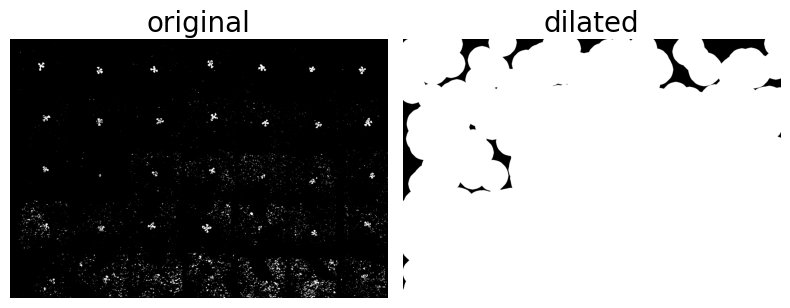

In [10]:
original_mask = '/home/mcaroulle/Pheno_Leaf/PL_Final/SEGMENTED_INPUT/TRAY10707.png'

mask_dilated, n= process_mask_dilation(original_mask)



# display results
original = io.imread(original_mask)

print('The mask kas been dilated trough',n,'dilations')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(original, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(mask_dilated, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('dilated', fontsize=20)

fig.tight_layout()
plt.show()


### rosette_center_coord()

In [11]:
x,y = Rosette_center_coord (mask_dilated, n)






#display results

skeleton_original = skeletonize(original)
skeleton_dilated = skeletonize(mask_dilated)

g, nodes = graph.pixel_graph(skeleton_original, connectivity=2)
px, distances = graph.central_pixel(g, nodes=nodes, shape=skeleton_original.shape, partition_size=100)

# Find the centroid of the skeletonized image
centroid_original = measure.centroid(skeleton_original)
centroid_dilated = measure.centroid(skeleton_dilated)

# display results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(color.label2rgb(skeleton_original, original))
ax[0].scatter(px[1], px[0], label='graph center')
ax[0].scatter(centroid_original[1], centroid_original[0], label='centroid')
ax[0].legend()
ax[0].set_axis_off()
ax[0].set_title('rosette graph center vs centroid',fontsize=10)

ax[1].imshow(color.label2rgb(skeleton_dilated, mask_dilated))
ax[1].scatter(x,y, label='graph center')
ax[1].scatter(centroid_dilated[1], centroid_dilated[0], label='centroid')
ax[1].legend()
ax[1].set_axis_off()
ax[1].set_title('rosette graph center vs centroid',fontsize=10)

ax[2].imshow(color.label2rgb(skeleton_dilated, original))
ax[2].scatter(x,y, label='graph center')
ax[2].legend()
ax[2].set_axis_off()
ax[2].set_title('Applied on original image',fontsize=10)

fig.tight_layout()
plt.show()

MemoryError: Unable to allocate 3.69 GiB for an array with shape (495050396,) and data type int64

### find_diameter()

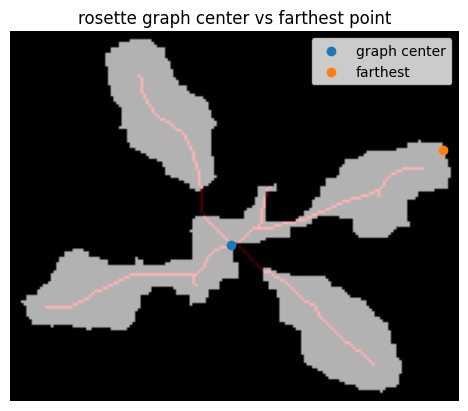

The diameter of the rosette is  85.492689745966 pixels


In [ ]:
diameter = find_diameter(original_mask)




#Display results (It only work if n is smaller enougth to chose graph center rather than centroid)
edges = feature.canny(original, sigma=0.6)
contours, _ = cv2.findContours(edges.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

max_distance = 0
farthest_point = None

for contour in contours:
    for point in contour:
        distance = np.linalg.norm(np.subtract((x,y), point[0]))
        if distance > max_distance:
            max_distance = distance
            farthest_point = point[0]

_, ax = plt.subplots()
ax.imshow(color.label2rgb(skeleton_dilated, original))
ax.scatter(x, y, label='graph center')
ax.scatter(farthest_point[0], farthest_point[1], label='farthest')
ax.legend()
ax.set_axis_off()
ax.set_title('rosette graph center vs farthest point')

plt.show()

print('The diameter of the rosette is ',diameter,'pixels')

### extract_regionprops_data()

In [ ]:
Tuple = extract_regionprops_data(original)

'area', 'area_convex', 'equivalent_diameter_area', 'solidity', 'eccentricity'
print('The area is ',Tuple[0],'pixels')
print('The area of the convex hull is ',Tuple[1],'pixels')
print('The equivalent diameter area is ',Tuple[2],'pixels')
print('The solidity is ',Tuple[3])
print('The eccentricity is ',Tuple[4])


The area is  5576.0 pixels
The area of the convex hull is  14280.0 pixels
The equivalent diameter area is  84.25902741809489 pixels
The solidity is  0.3904761904761905
The eccentricity is  0.6766755975988005
